# Daily Object Packaging Image Classification

**Brief Problem Statement**
This project focuses on developing a multi-class image classification system designed to identify various types of consumer product packaging. Given its utility in retail analytics, inventory automation, and sustainable recycling systems, automated packaging recognition remains a highly relevant field of study. Leveraging the vast availability of e-commerce and promotional imagery online, I will compile a custom dataset using DuckDuckGo image scraping. The dataset will prioritize clear, front-facing views while maintaining diverse environmental and branding variations. Following a rigorous cleaning and preprocessing phase, the data will be used to benchmark three distinct deep learning architectures. The final model selection will be determined by a comparative analysis of validation accuracy and loss metrics.

**Categories**
1. Bottled Water
2. Soft Drink Cans
3. Milk Cartons
4. Snack Chips Packets
5. Chocolate Bars
6. Instant Noodles Packets
7. Toothpaste Boxes
8. Shampoo Bottles
9. Soap Bars
10. Cooking Oil Bottles
11. Coffee Jars
12. Detergent Packs

# Setting Up Necessary Things

In [1]:
batch_size = 32
model_version = 0
%matplotlib inline

In [2]:
!pip install -Uqq fastai
!pip uninstall fastprogress

Found existing installation: fastprogress 1.1.3
Uninstalling fastprogress-1.1.3:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/fastprogress-1.1.3.dist-info/*
    /usr/local/lib/python3.12/dist-packages/fastprogress/*
Proceed (Y/n)? y
  Successfully uninstalled fastprogress-1.1.3


In [3]:

!pip install "fastprogress==1.0.3"


In [4]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Capstone2/daily_object_packaging_image

/content/drive/MyDrive/Capstone2/daily_object_packaging_image


# Fetch Data

In [7]:
data_path = Path("images")

In [8]:
!ls {data_path}

Bottled_Water	Cooking_Oil_Bottles	 Milk_Cartons	      Soap_Bars
Chocolate_Bars	Detergent_Packs		 Shampoo_Bottles      Soft_Drink_Cans
Coffee_Jars	Instant_Noodles_Packets  Snack_Chips_Packets  Toothpaste_Boxes


In [9]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,                        # recursively get all images in path
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # 90-10 train/validation split
    get_y=parent_label,                               # folder name as label
    item_tfms=Resize(128),                            # resize images to 128x128
    batch_tfms=Normalize.from_stats(*imagenet_stats)  # optional: normalize like ImageNet
)

In [10]:
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = dblock.dataloaders(data_path, bs = batch_size)
torch.save(dls, f"dataloaders/pkg_dataloader_v{model_version}.pkl")

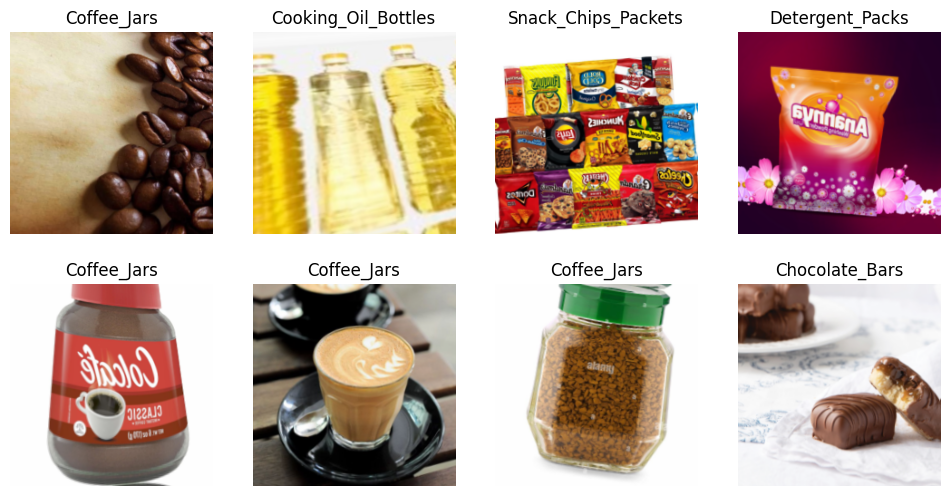

In [11]:
dls.train.show_batch(max_n=8, nrows=2)

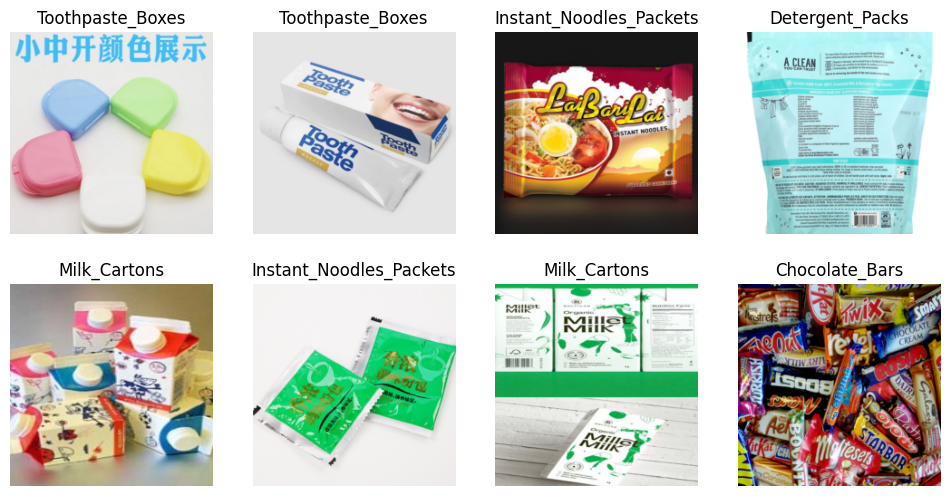

In [12]:
dls.valid.show_batch(max_n=8, nrows=2)

# Model Training

In [13]:
model_path = "models"

In [14]:
model = vision_learner(dls, resnet34, metrics=[error_rate,accuracy])
# model = vision_learner(dls, , metrics=[error_rate,accuracy])
# model = vision_learner(dls, , metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 217MB/s]


In [15]:
# model.load(f"pkg_dataloader_v{model_version}")

In [16]:
# help(ProgressCallback)

In [17]:
model.fine_tune(5)

In [18]:
model.save(f"pkg_recognizer_v{model_version+1}")

Path('models/pkg_dataloader_v1.pth')

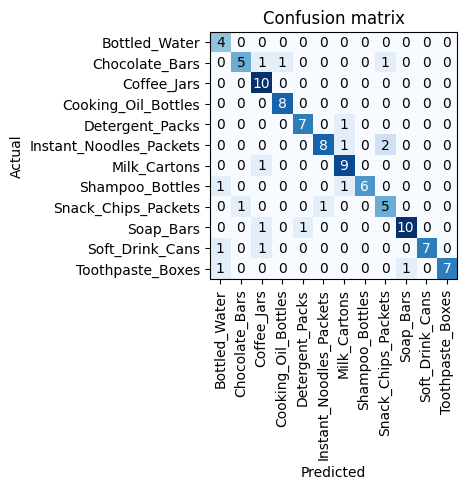

In [19]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

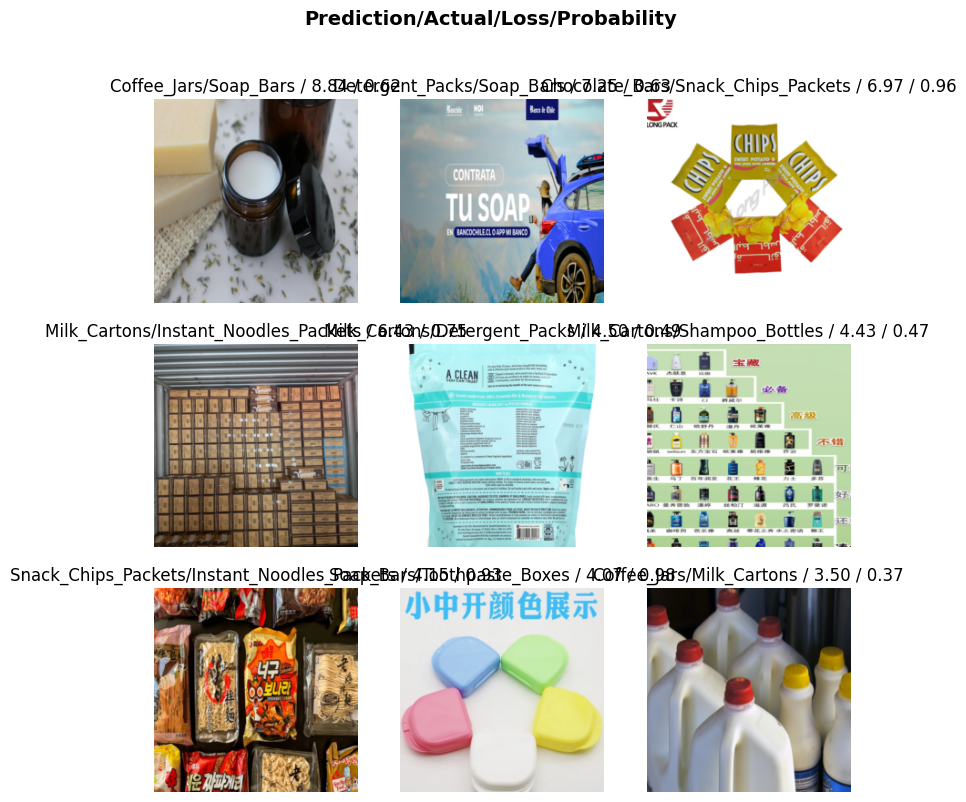

In [20]:
interp.plot_top_losses(9, nrows=3)

# Data Cleaning

In [21]:
cleaner = ImageClassifierCleaner(model)
cleaner

In [22]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()                                    # delete irrelevant data
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), f"{data_path}/{cat}") # change the directory

# Model Export for Inference

In [23]:
model.export(f"{model_path}/pkg_recognizer_v{model_version+1}")